In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from transformers import DeiTModel, DeiTFeatureExtractor, Trainer, TrainingArguments, AutoModel
from torchvision import transforms
import matplotlib.pyplot as plt
from fracture_dataset import FractureDataset
from utils import compute_metrics, compute_additional_metrics, plot_confusion_matrix, compute_all_metrics_with_ci

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = "AI FRACTURES"

feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-tiny-patch16-224")

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

with open("fracture_data_split.pkl", "rb") as f:
    split_data = pickle.load(f)

train_dataset = FractureDataset(split_data["train"], split_data["train_labels"], root_dir, image_transform, tokenizer=None)
test_dataset = FractureDataset(split_data["test"], split_data["test_labels"], root_dir, image_transform, tokenizer=None)
val_dataset = FractureDataset(split_data["val"], split_data["val_labels"], root_dir, image_transform, tokenizer=None)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\transformers\models\deit\feature_extraction_deit.py:30: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


In [3]:
class Model_DeiT(nn.Module):
    def __init__(self, num_labels=1):
        super(Model_DeiT, self).__init__()

        self.deit = DeiTModel.from_pretrained("facebook/deit-tiny-patch16-224")

        # Freeze the DeiT model parameters
        for param in self.deit.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.deit.config.hidden_size, num_labels)

        self.num_labels = num_labels

    def forward(self, pixel_values=None, labels=None):
        outputs = self.deit(pixel_values=pixel_values)
        pooled_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(self.dropout(pooled_output))

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits, labels)
    
        return {
            "loss": loss,
            "logits": logits
        }

In [4]:
def collate_fn(batch):
    images = torch.stack([item["pixel_values"][0] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return {
        "pixel_values": images,
        "labels": labels
    }

In [5]:
model = Model_DeiT(num_labels=1)

# Training setup
training_args = TrainingArguments(
    output_dir='./deit_fracture_output',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=5e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator = collate_fn,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

In [6]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,0.696500,0.650733,0.500000,0.000000,0.500000
2,0.711300,0.665611,0.500000,0.000000,0.500000
3,0.714300,0.692238,0.500000,0.000000,0.500000
4,0.676600,0.713816,0.500000,0.000000,0.500000
5,0.684900,0.699883,0.400000,0.000000,0.400000
6,0.649300,0.726137,0.500000,0.000000,0.500000
7,0.642000,0.753606,0.500000,0.444444,0.500000
8,0.650200,0.712123,0.600000,0.600000,0.600000
9,0.694600,0.715661,0.600000,0.333333,0.600000
10,0.879400,1.756632,0.500000,0.666667,0.500000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [7]:
torch.save(model.state_dict(), "deit_fracture_model.pth")

In [8]:
# Save the model
trainer.save_model()

In [9]:
# Evaluate
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.75663161277771,
 'eval_accuracy': 0.5,
 'eval_f1': 0.6666666666666666,
 'eval_roc_auc': 0.5,
 'eval_runtime': 1.9901,
 'eval_samples_per_second': 5.025,
 'eval_steps_per_second': 1.005,
 'epoch': 10.0}

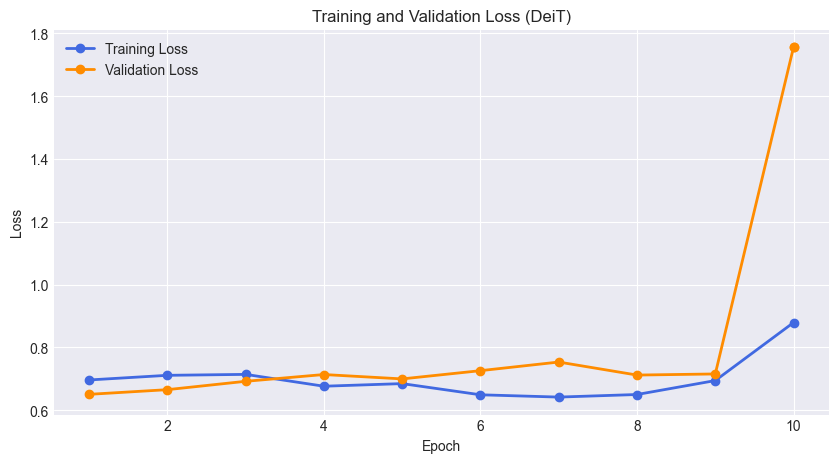

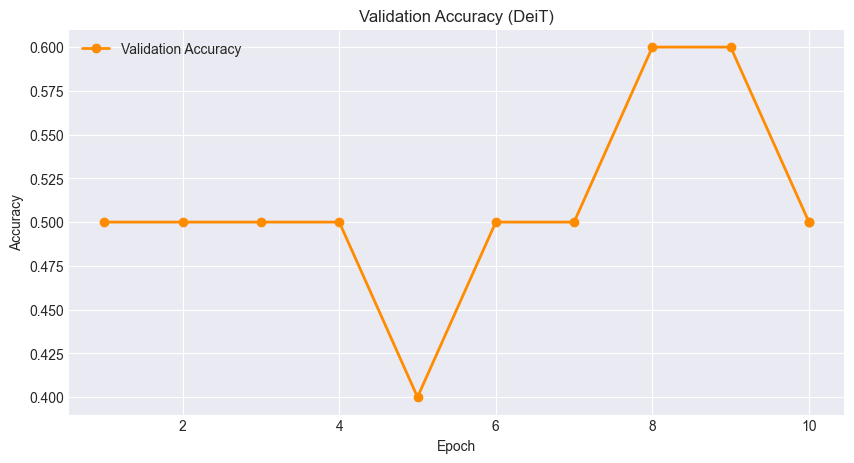

In [10]:
# Extract logs
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
train_epochs = []
eval_epochs = []

for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # store matching epoch
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.style.use('seaborn-v0_8-darkgrid')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker='o', linewidth=2, color='royalblue')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o', linewidth=2, color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (DeiT)")
plt.legend()
plt.grid(True)
plt.savefig("deit_fracture_loss.png")
plt.show()

# Plot Accuracy (optional, if accuracy was computed)
if eval_accuracy:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy", marker='o', linewidth=2, color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy (DeiT)")
    plt.legend()
    plt.grid(True)
    plt.savefig("deit_fracture_accuracy.png")
    plt.show()

In [6]:
model.load_state_dict(torch.load("deit_fracture_model.pth"))
# Evaluate on test set
trainer.evaluate(test_dataset)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.773280143737793,
 'eval_model_preparation_time': 0.0033,
 'eval_accuracy': 0.4,
 'eval_f1': 0.5714285714285714,
 'eval_roc_auc': 0.4,
 'eval_runtime': 2.5025,
 'eval_samples_per_second': 3.996,
 'eval_steps_per_second': 0.799}

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


f1: 0.6667
roc_auc: 0.5000
matthews_corrcoef: 0.0000
brier_score: 0.5000
sensitivity: 1.0000
specificity: 0.0000
balanced_accuracy: 0.5000


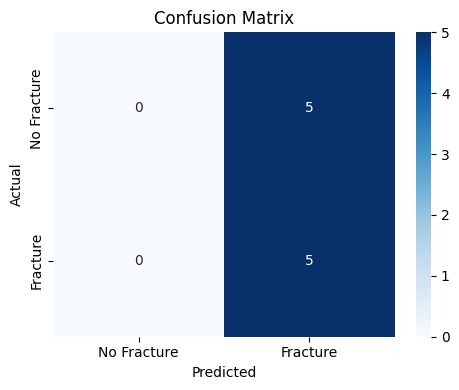

In [7]:
# Run evaluation
predictions = trainer.predict(test_dataset)

# Extract logits and compute probabilities using sigmoid if binary
logits = predictions.predictions
y_pred_probs = 1 / (1 + np.exp(-logits))  # Sigmoid for binary
y_pred_probs = y_pred_probs.squeeze()    # Remove extra dimension if needed
y_pred = (y_pred_probs >= 0.5).astype(int)  # Get predicted class labels

# Ground truth labels
y_true = predictions.label_ids.squeeze()

# Compute and print metrics
metrics = compute_additional_metrics(y_true, y_pred)
for key, value in metrics.items():
    if key != "confusion_matrix":
        print(f"{key}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"])

In [10]:
print("Confidence scores for test set:")
for i, score in enumerate(y_pred_probs):
    if y_pred[i] == 1:
        print(f"Sample {i+1}: {score:.4f} confidence for fracture")
    else:
        print(f"Sample {i+1}: {1-score:.4f} confidence for no fracture")

Confidence scores for test set:
Sample 1: 0.9376 confidence for fracture
Sample 2: 0.9940 confidence for fracture
Sample 3: 0.9641 confidence for fracture
Sample 4: 0.5691 confidence for fracture
Sample 5: 0.9648 confidence for fracture
Sample 6: 0.9653 confidence for fracture
Sample 7: 0.9722 confidence for fracture
Sample 8: 0.9788 confidence for fracture
Sample 9: 0.8271 confidence for fracture
Sample 10: 0.9604 confidence for fracture


In [13]:
results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=False)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Error computing sensitivity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-pack

accuracy: 0.497 (90% CI: 0.200 - 0.800)
f1: 0.652 (90% CI: 0.333 - 0.889)
auroc: 0.438 (90% CI: 0.120 - 0.793)
mcc: 0.000 (90% CI: 0.000 - 0.000)
brier: 0.501 (90% CI: 0.200 - 0.700)
sensitivity: 1.000 (90% CI: 1.000 - 1.000)
specificity: 0.000 (90% CI: 0.000 - 0.000)
balanced_accuracy: 0.500 (90% CI: 0.500 - 0.500)


In [14]:
model = Model_DeiT(num_labels=1)
model.eval()
model.load_state_dict(torch.load("deit_fracture_model.pth"))

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

<All keys matched successfully>

In [15]:
# from torchview import draw_graph

# sample_input = next(iter(train_dataset))
# dummy_inputs = {
#     "pixel_values": sample_input["pixel_values"][0].unsqueeze(0)  # Add batch dimension
# }

# # Pass the inputs to your model (unpack the dictionary)
# output = model(
#     pixel_values=dummy_inputs["pixel_values"]
# )

# model_graph = draw_graph(
#     model,
#     input_data={
#         "pixel_values": dummy_inputs["pixel_values"],
#     },
#     graph_name='DeiT Fracture Model Graph',
#     save_graph=True,
#     expand_nested=False
# )